In [5]:
import numpy as np
np.float = np
np.int = np

In [ ]:
# pip install river

   ---------------------------------------- 0.0/1.9 MB ? eta -:--:--
   ---------------------------------------- 1.9/1.9 MB 11.4 MB/s  0:00:00
Note: you may need to restart the kernel to use updated packages.


In [6]:
import sys
import numpy as np
import pandas as pd
from river import preprocessing
from sklearn.neural_network import MLPClassifier
from skmultiflow.data.data_stream import DataStream
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
from D3 import D3
import pickle
import warnings

warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv('./경진대회용 주조 공정최적화 데이터셋.csv', encoding = 'euc-kr', index_col = 0)
df.dropna(subset=['emergency_stop', 'upper_mold_temp3','lower_mold_temp3'], inplace=True)
df = df[['registration_time','facility_operation_cycleTime','production_cycletime', 'low_section_speed', 'high_section_speed','cast_pressure', 'biscuit_thickness',
       'upper_mold_temp1', 'upper_mold_temp2', 'upper_mold_temp3','lower_mold_temp1', 'lower_mold_temp2', 'lower_mold_temp3','sleeve_temperature', 'physical_strength', 'Coolant_temperature',
       'EMS_operation_time','passorfail']]
df['registration_time'] = pd.to_datetime(df['registration_time'])
display(df)

,registration_time,facility_operation_cycleTime,production_cycletime,low_section_speed,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,upper_mold_temp3,lower_mold_temp1,lower_mold_temp2,lower_mold_temp3,sleeve_temperature,physical_strength,Coolant_temperature,EMS_operation_time,passorfail
0,2019-01-02 16:45:06,119,120,110.0,112.0,331.0,35.0,198.0,116.0,1449.0,234.0,316.0,1449.0,550.0,700.0,34.0,23,0.0
22,2019-01-02 17:27:28,119,120,109.0,125.0,177.0,48.0,24.0,33.0,1449.0,30.0,273.0,1449.0,479.0,708.0,35.0,23,1.0
24,2019-01-02 17:29:32,119,123,109.0,112.0,176.0,49.0,26.0,55.0,1449.0,30.0,323.0,1449.0,513.0,700.0,35.0,23,1.0
26,2019-01-02 17:31:41,119,124,109.0,112.0,331.0,47.0,31.0,65.0,1449.0,30.0,343.0,1449.0,531.0,708.0,34.0,23,1.0
28,2019-01-02 17:33:39,120,124,110.0,112.0,331.0,46.0,36.0,73.0,1449.0,31.0,343.0,1449.0,544.0,707.0,34.0,23,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92010,2019-03-31 23:51:29,122,122,100.0,101.0,331.0,49.0,83.0,183.0,1449.0,231.0,201.0,1449.0,279.0,726.0,30.0,0,0.0
92011,2019-03-31 23:53:28,120,121,100.0,101.0,331.0,54.0,83.0,184.0,1449.0,232.0,201.0,1449.0,279.0,732.0,30.0,0,0.0
92012,2019-03-31 23:55:44,122,135,100.0,101.0,331.0,52.0,79.0,184.0,1449.0,225.0,195.0,1449.0,272.0,731.0,30.0,0,0.0
92013,2019-03-31 23:57:46,133,122,100.0,101.0,331.0,53.0,82.0,185.0,1449.0,227.0,199.0,1449.0,288.0,723.0,30.0,0,0.0


In [9]:
train_df = df[df['registration_time'] <= '2019-01-30 08:00:00']
test_df = df[df['registration_time'] > '2019-01-30 08:00:00']
train_X = train_df.drop(['registration_time','passorfail'],axis=1)
train_y = train_df['passorfail']
test_X = test_df.drop(['registration_time','passorfail'],axis=1)
test_y = test_df['passorfail']

print(train_df.shape)
print(test_df.shape)

(26461, 18)
(65241, 18)


### Offline model

In [ ]:
scaler = preprocessing.StandardScaler()

scaler.learn_many(train_X)
train_X_scaled = scaler.transform_many(train_X).values
test_X_scaled = scaler.transform_many(test_X).values

model = MLPClassifier((16,8),activation='relu',solver='adam',alpha=0, batch_size = 200, learning_rate = 'constant',
                      learning_rate_init = 0.001, max_iter = 100, early_stopping = False, random_state=2)
model.fit(train_X_scaled, train_y.values)

y_pred = model.predict(test_X_scaled)
accuracy = accuracy_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)
report = classification_report(test_y, y_pred)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)

Accuracy: 0.9458316089575574
F1 Score: 0.5517503805175038
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.95      0.97     62354
         1.0       0.44      0.75      0.55      2887

    accuracy                           0.95     65241
   macro avg       0.71      0.85      0.76     65241
weighted avg       0.96      0.95      0.95     65241



In [ ]:
test_y = test_y
chunk_num = 30
chunk_size = len(y_pred) // chunk_num

acc_list = []
f1_list = []

for i in range(chunk_num):
    start_idx = i*chunk_size
    end_idx = (i+1)*chunk_size
    if i == (chunk_num-1):
        chunk_y = test_y[start_idx:]
        chunk_pred = y_pred[start_idx:]
    else:
        chunk_y = test_y[start_idx:end_idx]
        chunk_pred = y_pred[start_idx:end_idx]

    acc_list.append(accuracy_score(chunk_y, chunk_pred))
    f1_list.append(f1_score(chunk_y, chunk_pred))

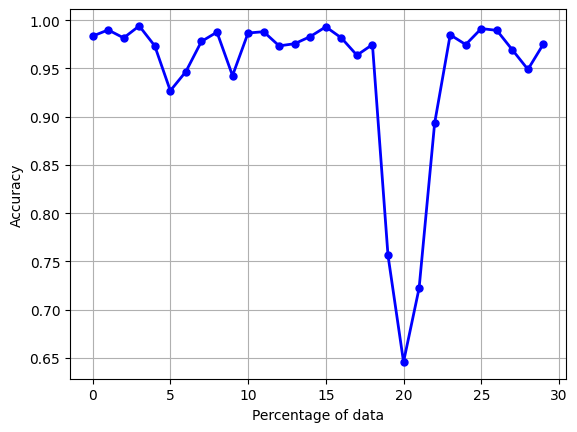

In [ ]:
plt.plot(range(30), acc_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Percentage of data')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

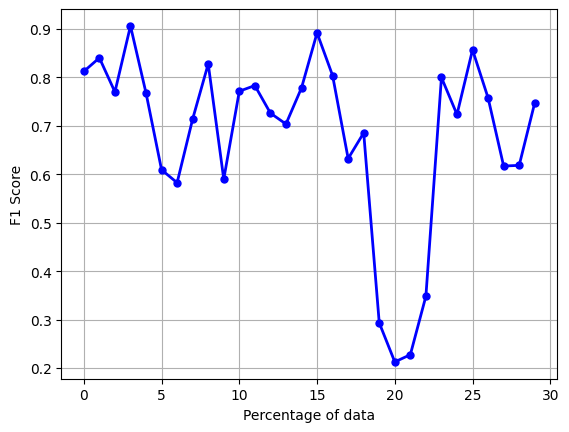

In [ ]:
plt.plot(range(30), f1_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Percentage of data')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

In [ ]:
#Save model
with open('./20190130_0800_adaptivemlp.pkl', 'wb') as file:
    pickle.dump(model, file)

### Online

In [ ]:
del model

In [11]:
#load model
with open('model_params/20190130_0800_adaptivemlp.pkl', 'rb') as file:
    model = pickle.load(file)

In [12]:
scaler = preprocessing.StandardScaler()
scaler.learn_many(train_X)

In [ ]:
pred_li = []
i = 0
w_size = 400
rho = 0.5

stream = DataStream(data = test_X, y= test_y)
d3 = D3(w=w_size, rho=rho, dim = 16, auc = 0.85)

for x,y in zip(train_X.values[-w_size:,:],train_y.values[-w_size:]):
  d3.addInstance(x,y)

while(stream.has_more_samples()):
  X,y = stream.next_sample()
  dict_X = {key: value for key, value in zip(list(scaler.means.keys()),np.squeeze(X))}
  #scaler.learn_one(dict_X)
  X_scaled = scaler.transform_one(dict_X)
  X_scaled = np.array(list(X_scaled.values()))
  X_scaled = np.expand_dims(X_scaled, axis=0)

  if d3.isEmpty():
    d3.addInstance(X,y)
    y_hat = model.predict(X_scaled)
    pred_li.append(y_hat.item())
  else:
    if d3.driftCheck():
      print("concept drift detected at {}".format(i))

      y_hat = model.predict(X_scaled)
      drift_X, drift_y = d3.getCurrentData(), d3.getCurrentLabels()
      scaler.learn_many(pd.DataFrame(drift_X, columns = list(scaler.means.keys())))
      drift_X_scaled = scaler.transform_many(pd.DataFrame(drift_X, columns = list(scaler.means.keys())))
      for epoch in range(20):
        model.partial_fit(drift_X_scaled.values, d3.getCurrentLabels())
      pred_li.append(y_hat.item())
      d3.addInstance(X,y)
    else:
      y_hat = model.predict(X_scaled)
      pred_li.append(y_hat.item())
      d3.addInstance(X,y)
  i = i+1

#print(pred_li)
#save_result = pd.DataFrame(pred_li)
#save_result.to_csv('/content/drive/MyDrive/KAMP_제출용/예측 결과 저장/20190116_0800_adaptiverf_online.csv')

concept drift detected at 200
concept drift detected at 1000
concept drift detected at 2000
concept drift detected at 2600
concept drift detected at 3200
concept drift detected at 3800
concept drift detected at 4400
concept drift detected at 4800
concept drift detected at 5200
concept drift detected at 5600
concept drift detected at 6000
concept drift detected at 6600
concept drift detected at 7200
concept drift detected at 7800
concept drift detected at 8400
concept drift detected at 8800
concept drift detected at 9400
concept drift detected at 9800
concept drift detected at 10200
concept drift detected at 10600
concept drift detected at 11000
concept drift detected at 11400
concept drift detected at 11800
concept drift detected at 12400
concept drift detected at 12800
concept drift detected at 13400
concept drift detected at 13800
concept drift detected at 14200
concept drift detected at 14600
concept drift detected at 15000
concept drift detected at 15400
concept drift detected at 1

In [ ]:
accuracy = accuracy_score(test_y, pred_li)
f1 = f1_score(test_y, pred_li)
report = classification_report(test_y, pred_li)

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Classification Report:\n", report)

Accuracy: 0.9823270642694012
F1 Score: 0.7868367535588834
Classification Report:
               precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     62354
         1.0       0.84      0.74      0.79      2887

    accuracy                           0.98     65241
   macro avg       0.92      0.87      0.89     65241
weighted avg       0.98      0.98      0.98     65241



In [ ]:
chunk_num = 30
chunk_size = len(test_y) // chunk_num

acc_list = []
f1_list = []

for i in range(chunk_num):
    start_idx = i*chunk_size
    end_idx = (i+1)*chunk_size
    if i == (chunk_num-1):
        chunk_y = test_y[start_idx:]
        chunk_pred = pred_li[start_idx:]
    else:
        chunk_y = test_y[start_idx:end_idx]
        chunk_pred = pred_li[start_idx:end_idx]

    acc_list.append(accuracy_score(chunk_y, chunk_pred))
    f1_list.append(f1_score(chunk_y, chunk_pred))

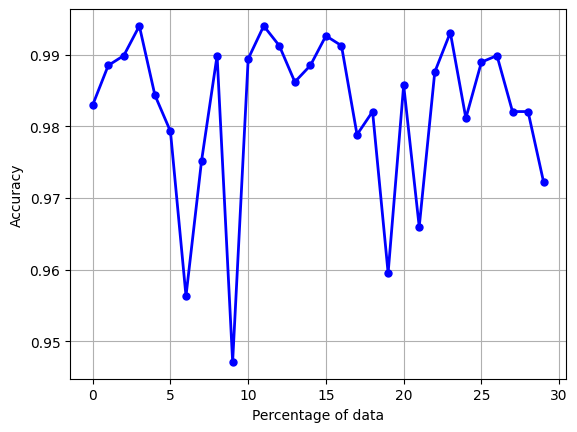

In [ ]:
plt.plot(range(30), acc_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Percentage of data')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

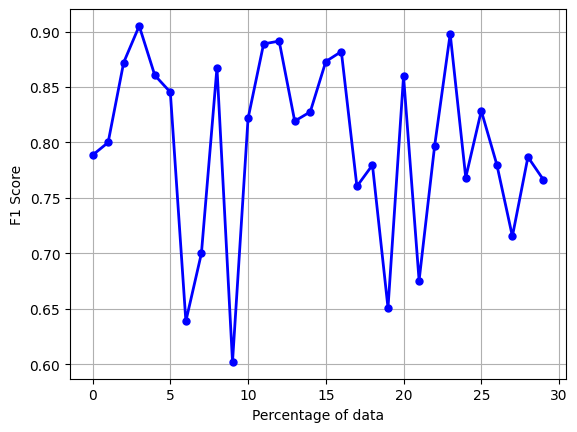

In [ ]:
plt.plot(range(30), f1_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=5)
plt.xlabel('Percentage of data')
plt.ylabel('F1 Score')
plt.grid(True)
plt.show()

### 시각화

In [ ]:
test_y = mlp_perf['ground_truth'].values
on_pred = pred_li
off_pred = y_pred

chunk_num = 30
chunk_size = len(test_y) // chunk_num

on_acc_list = []
on_f1_list = []
off_acc_list = []
off_f1_list = []

for i in range(chunk_num):
    start_idx = i*chunk_size
    end_idx = (i+1)*chunk_size
    if i == (chunk_num-1):
        chunk_y = test_y[start_idx:]
        on_chunk_pred = on_pred[start_idx:]
        off_chunk_pred = off_pred[start_idx:]
    else:
        chunk_y = test_y[start_idx:end_idx]
        on_chunk_pred = on_pred[start_idx:end_idx]
        off_chunk_pred = off_pred[start_idx:end_idx]

    on_acc_list.append(accuracy_score(chunk_y, on_chunk_pred))
    off_acc_list.append(accuracy_score(chunk_y, off_chunk_pred))
    on_f1_list.append(f1_score(chunk_y, on_chunk_pred))
    off_f1_list.append(f1_score(chunk_y, off_chunk_pred))

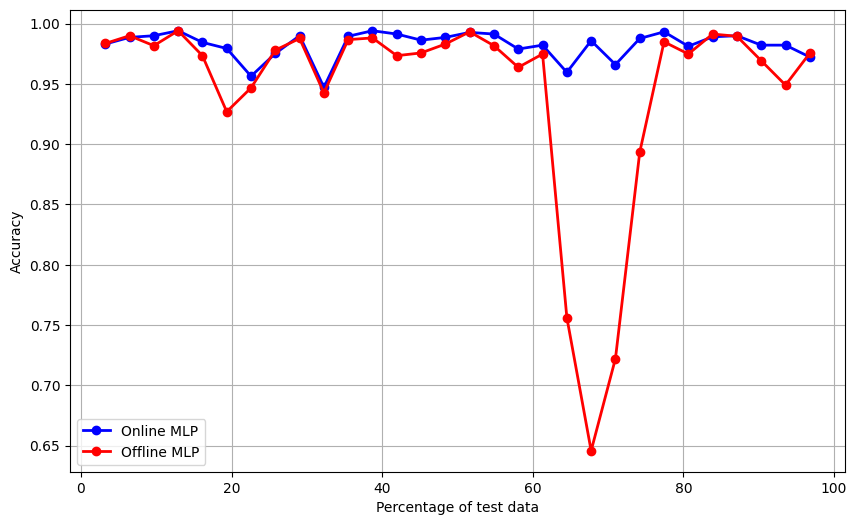

In [ ]:
plt.figure(figsize=(10, 6))

xlabel = np.linspace(0, 100, 32)[1:-1]
plt.plot(xlabel, on_acc_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=6, label = 'Online MLP')
plt.plot(xlabel, off_acc_list, marker='o', color='r', linestyle='-', linewidth=2, markersize=6, label = 'Offline MLP')
plt.xlabel('Percentage of test data')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

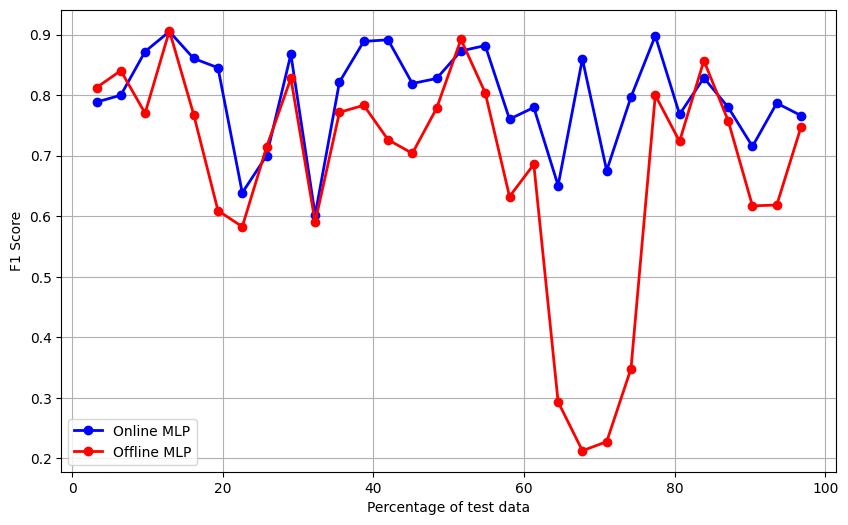

In [ ]:
plt.figure(figsize=(10, 6))

xlabel = np.linspace(0, 100, 32)[1:-1]
plt.plot(xlabel, on_f1_list, marker='o', color='b', linestyle='-', linewidth=2, markersize=6, label = 'Online MLP')
plt.plot(xlabel, off_f1_list, marker='o', color='r', linestyle='-', linewidth=2, markersize=6, label = 'Offline MLP')
plt.xlabel('Percentage of test data')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
mlp_perf = pd.DataFrame()
mlp_perf['ground_truth'] = test_y
mlp_perf['offline_pred'] = y_pred
mlp_perf['online_pred'] = pred_li

mlp_perf.to_csv('test_results/20190130_0800_MLP_result(400,0.5,0.85).csv')
